# Blank Notebook

This is a blank notebook that eases the process of this lab by reducing the coding one a student has to do.

In [8]:
%matplotlib notebook
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import scipy.optimize

from decimal import Decimal #print("{:.#F}.format(Decimal(value))")
from math import pi #pi = 3.1415926535897.......

In [2]:
#define at a function describing double slit interference 
def double_slit(B,theta):
    # B is a vector of the parameters.
    # B[0] is the normalization factor
    # B[1] is the slit speration divided by the wavelength of light
    # B[2] is the slit width divided by the wavelength of light
    # theta is the angle from the optical path straigh through the slits
    return B[0]*np.cos(pi*B[1]*np.sin(theta))**2*np.sinc(pi*B[2]*np.sin(theta))**2

In [3]:
#Converts the position of the detector slit in to the angle of diffraction.
#The position of measurements x and position of the central maximum, x_max.
def theta_conversion(x,x_max,distance):
    theta=(x-x_max)/distance/1000 #This assumes your data is logged in millimeters
    return theta

In [ ]:
#organized as columns 0,1,2,3 respectively: 
#position double slit, intensity double slit
#position single slit, intensity single slit
#as long as the notebook and the data are in the same folder, you just need the filename
filename = "redLaser.csv" #make an excel document then do "save as" and select .CSV(Comma delimited) (*.csv)
photon_data = np.loadtxt(filename,delimiter=',', skiprows=2,usecols=[0,1,2,3])

# Begining of Mode 2

In [ ]:
#odr is unable to make multiple instances so you have to import whenever you call odr.RealData()
import scipy.odr as odr
# mode 2

#Double Slit
#Position Data
x = photon_data[:,0]
x_err = 0.01 #from our notebook

#Intensity data(voltage)
y = photon_data[:,1]
y_err = 0.005 #from the lab notebook

#Single Slit
#Position Data
x_1 = photon_data[:,2]
x_err1 = 0.01 #from our notebook

#Intensity data(voltage)
y_1 = photon_data[:,3]
y_err1 = 0.005 #from the lab notebook

#Need a table of x and y values and there uncertainties. Here the y values are the intensities and x values are the angles
#We have to calculate the angles using the measured distance between the double slit and the detector slit.
#This is about 0.5 meters and the slit measurement positions are in millimeters so
distance = 0.5 #m #distance between double and detector slits in meters
Intensities = y #set Intensities equal to the y data
x_max = 2.85 #from reading off the first plot, this is zero angle

#The errorbars for this data are pretty small, so we can't actually seem them on the plot below.
#Setup ODR
#Initial estimates of parameters
#The parameters are the maximum intensity, slit seperation divided by the wavelength of light, 
#and slit width divided by the wavelength of light

wavelength = 632.8e-9 #in meters
slit_separatition_guess = 0.333e-3 #in meters
slit_width_guess = 0.0242e-3 #in meters
maximum_intensity_guess = 5.15 #in volts

intial = [maximum_intensity_guess,slit_separatition_guess/wavelength,slit_width_guess/wavelength]

#angular positions of the intensitiy measuremenst
theta_data = theta_conversion(x,x_max,distance)

#The ODR "RealData" function will take in this order, x, y, sx, sy where sx and sy 
# are the standard deviations of the x and y measurements,i.e. their errors.
#If we had a column in or data, we could just use that, instead we will have to make one.

#since the errors are uniform for the intensitites measruements (the y values) need to make 
#an array the same length as the data and multiply by yerr
sy = yerr*np.ones(len(y)) 

#since the errors are uniform and on positition, take the relative position errors 
#times the theta, the angles, times the array of 1's the same
#length as the data

sx = (1/(1000*distance))*(xerr)*np.ones(len(x))

#now make the model to put into odr
double_slit_model = odr.Model(double_slit)
#Now make the data object to put into ODR
data = odr.RealData(theta_data,Intensities,sx=sx,sy=sy)

<IPython.core.display.Javascript object>


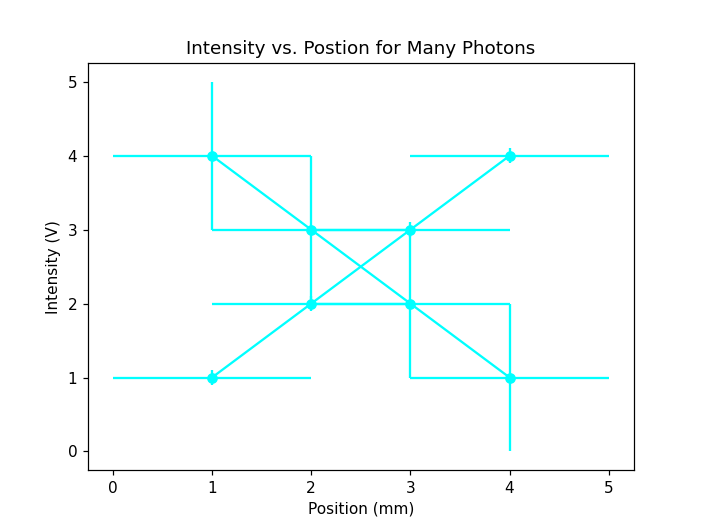

Text(0.5, 1.0, 'Intensity vs. Postion for Many Photons')

In [27]:
plt.figure("Intensity vs. Postion for Many Photons") #define the figure

plt.errorbar(x, y, y_err, x_err, 'o-', color='magenta') #plot the data
# You can add a second set of data to the same plot by just calling "plt.errorbar" again, but put in defferent data
# for x, y, and xerr, yerr

plt.errorbar(x1, y1, y_err1, x_err1,'o-',color='cyan') #plot the data
plt.ylabel('Intensity (V)')
plt.xlabel('Position (mm)')
plt.title("Intensity vs. Postion for Many Photons")

In [ ]:
odr = odr.ODR(data,double_slit_model, beta0=intial)
#Run ODR
out = odr.run()
#Print Results
out.pprint()

In [ ]:
#Fit values
I_0 = out.beta[0]
S_fit = out.beta[1]*wavelength
W_fit = out.beta[2]*wavelength

#Fit errors
I_0_err = out.sd_beta[0]
S_fit_err = out.sd_beta[1]/out.beta[1]*S_fit
W_fit_err = out.sd_beta[2]/out.beta[2]*W_fit

#Error of the parameters
print("Fit Intensity: %.2f +/- %.2f Volts" %(I_0, I_0_err))
print("Separation: %.3f +/- %.3f mm" %(S_fit*1000, S_fit_err*1000))
print("Width  %.1f +/- %.1f microns" % (W_fit*10**6, W_fit_err*10**6)) 

In [ ]:
# Define the data
# For the x data, we want a smooth variation from the min and maximum values of the measrued data
x_fit = np.arange(min(x),max(x),0.001) #this will make potision from the max to min in steps of 0.001

# To get the y values, we put our x values, convert them to angles, and then put them and the output fit parameters B into our
# function for the double slit
y_fit = double_slit(out.beta,theta_conversion(x_fit,x_max,distance))

plt.figure("Intensity vs. Postion for Many Photons \n with fit graph") #need to make a 2nd figure otherwise, our plots will be put into figure 2
#plot the fit equations
plt.plot(x_fit,y_fit,'-',color='cyan',linewidth=2) #we don't need errorbars so we can just use "plot"
#plot the measured data for comparison
plt.errorbar(x,y,xerr,yerr,'o-',color='magenta')
plt.ylabel('Intensity (V)')
plt.xlabel('Position (mm)')
plt.title("Intensity vs. Postion for Many Photons \n with fit graph")

In [ ]:
plt.figure("Zoomed in view on the peaks of the above graph",figsize=(12,6)) #need to make a 2nd figure otherwise, our plots will be put into figure 2
ax1=plt.subplot(1,3,1)
ax1.plot(x_fit,y_fit,'-',color='cyan',linewidth=2) #we don't need errorbars so we can just use "plot"
ax1.errorbar(x,y,x_err,y_err,'o-',color='magenta')
plt.xlim(2.6,3.1)
plt.ylim(4,5.25)
plt.ylabel('Intensity (V)')

ax2=plt.subplot(1,3,2)
ax2.plot(x_fit,y_fit,'-',color='cyan',linewidth=2) #we don't need errorbars so we can just use "plot"
ax2.errorbar(x , y, x_err, y_err,'o-',color='magenta')
plt.xlim(3.6,4)
plt.ylim(3.8,4.6)
plt.xlabel('Position (mm)')
plt.title("Intensity vs. Postion for Many Photons \n with fit graph")

ax3=plt.subplot(1,3,3)
ax3.plot(x_fit,y_fit,'-',color='cyan',linewidth=2) #we don't need errorbars so we can just use "plot"
ax3.errorbar(x , y, x_err1, y_err1,'o-',color='magenta')
plt.xlim(4.5,4.9)
plt.ylim(2.2,2.8)

# Begining of mode 3

In [ ]:
#organized as columns 0,1,2,3 respectively: 
#position double slit, intensity double slit, uncertainity in double slit
#position single slit, intensity single slit, uncertainty in single slit
#as long as the notebook and the data are in the same folder, you just need the filename
filename = "greenLight.csv" #make an excel document then do "save as" and select .CSV(Comma delimited) (*.csv)
singlePhoton_data = np.loadtxt(filename,delimiter=',', skiprows=2,usecols=[0,1,2,3,4,5])

In [ ]:
import scipy.odr as odr
# mode 3

#Double Slit
#Position Data
x = photon_data[:,0]
x_err = 0.01 #from our notebook

#Intensity data(voltage)
y = photon_data[:,1]
y_err = photon_data[:,2]

#Single Slit
#Position Data
x_1 = photon_data[:,3]
x_err1 = 0.01 #from our notebook

#Intensity data(voltage)
y_1 = photon_data[:,4]
y_err1 = photon_data[:,5]

#Need a table of x and y values and there uncertainties. Here the y values are the intensities and x values are the angles
#We have to calculate the angles using the measured distance between the double slit and the detector slit.
#This is about 0.5 meters and the slit measurement positions are in millimeters so

distance = 0.5 #m #distance between double and detector slits in meters
Intensities = y #set Intensities equal to the y data
x_max = 3.449 #from reading off the first plot, this is zero angle

#Setup ODR
#Initial estimates of parameters
#The parameters are the maximum intensity, slit seperation divided by the wavelength of light, 
#and slit width divided by the wavelength of light

wavelength = 546e-9 #in meters
slit_separatition_guess = 0.352e-3 #in meters
slit_width_guess = 0.026e-3 #in meters
maximum_intensity_guess = 1428 #in volts

intial = [maximum_intensity_guess,slit_separatition_guess/wavelength,slit_width_guess/wavelength]

#angular positions of the intensitiy measuremenst
theta_data = theta_conversion(x,x_max,distance)

#The ODR "RealData" function will take in this order, x, y, sx, sy where sx and sy 
# are the standard deviations of the x and y measurements,i.e. their errors.
#If we had a column in or data, we could just use that, instead we will have to make one.

#since the errors are uniform for the intensitites measruements (the y values) need to make 
#an array the same length as the data and multiply by yerr
sy = yerr*np.ones(len(y)) 

#since the errors are uniform and on positition, take the relative position errors 
#times the theta, the angles, times the array of 1's the same
#length as the data

sx = (1/(1000*distance))*(xerr)*np.ones(len(x))

#Now make the data object to put into ODR
data = odr.RealData(theta_data,Intensities,sx=sx,sy=sy)

#now make the model to put into odr
double_slit_model = odr.Model(double_slit)

In [ ]:
plt.figure("Intensity vs. Postion for One Photon at a time") #define the figure
plt.errorbar(x,y,yerr,xerr,'o-',color='magenta') #plot the data
# You can add a second set of data to the same plot by just calling "plt.errorbar" again, but put in defferent data
# for x, y, and xerr, yerr
plt.errorbar(x_1,y_1,yerr_1,xerr_1,'o-',color='cyan') #plot the data
plt.ylabel('Intensity (Photons/Second)')
plt.xlabel('Position (mm)')
plt.title("Intensity vs. Postion for One Photon at a time")

In [ ]:
odr = odr.ODR(data,double_slit_model, beta0=intial)
#Run ODR
out = odr.run()
#Print Results
out.pprint()

In [ ]:
#Fit values
I_0 = out.beta[0]
S_fit = out.beta[1]*wavelength
W_fit = out.beta[2]*wavelength

#Fit errors
I_0_err = out.sd_beta[0]
S_fit_err = out.sd_beta[1]/out.beta[1]*S_fit
W_fit_err = out.sd_beta[2]/out.beta[2]*W_fit

#Error of the parameters
print("Fit Intensity: %.2f +/- %.2f Photons per second" %(I_0, I_0_err))
print("Separation: %.3f +/- %.3f mm" %(S_fit*1000, S_fit_err*1000))
print("Width  %.1f +/- %.1f microns" % (W_fit*10**6, W_fit_err*10**6)) 

In [ ]:
# Define the data
# For the x data, we want a smooth variation from the min and maximum values of the measrued data
x_fit = np.arange(min(x),max(x),0.01) #this will make potision from the max to min in steps of 0.01

# To get the y values, we put our x values, convert them to angles, and then put them and the output fit parameters B into our
# function for the double slit
#y_fit = double_slit(out.beta,theta_conversion(x_fit,x_max,distance))
y_fit = double_slit(intial,theta_conversion(x_fit,x_max,distance))

plt.figure("Intensity vs. Postion for One Photon at a time \n with fit graph") #need to make a 2nd figure otherwise, our plots will be put into figure 2
#plot the fit equations
plt.plot(x_fit,y_fit-230,'-',color='cyan',linewidth=2) #we don't need errorbars so we can just use "plot"
#plot the measured data for comparison
plt.errorbar(x,Intensities,yerr,xerr,'o-',color='magenta')
plt.ylabel('Intensity (Photons/Second)')
plt.xlabel('Position (mm)')
plt.title("Intensity vs. Postion for Many Photons")

In [ ]:
plt.figure("Intensity vs. Postion for One Photon at a time \n with fit graph zoomed in on the peaks",figsize=(12,6)) #need to make a 2nd figure otherwise, our plots will be put into figure 2
ax1=plt.subplot(1,3,1)
ax1.plot(x_fit,y_fit,'-',color='cyan',linewidth=2) #we don't need errorbars so we can just use "plot"
ax1.errorbar(x,y,yerr,xerr,'o-',color='magenta')
plt.xlim(3.35,3.55)
plt.ylim(1350,1450)
plt.ylabel('Intensity (V)')

ax2=plt.subplot(1,3,2)
ax2.plot(x_fit,y_fit,'-',color='cyan',linewidth=2) #we don't need errorbars so we can just use "plot"
ax2.errorbar(x,y,yerr,xerr,'o-',color='magenta')
plt.xlim(4,4.5)
plt.ylim(950,1300)
plt.xlabel('Position (mm)')
plt.title("Intensity vs. Postion for Many Photons")

ax3=plt.subplot(1,3,3)
ax3.plot(x_fit,y_fit,'-',color='cyan',linewidth=2) #we don't need errorbars so we can just use "plot"
ax3.errorbar(x,y,yerr,xerr,'o-',color='magenta')
plt.xlim(4.8,5.2)
plt.ylim(500,750)